In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from glob import glob
import os

from sklearn.preprocessing import StandardScaler

from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
import seaborn as sns

import pickle
import time
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from rerf.rerfClassifier import rerfClassifier

import warnings
warnings.simplefilter('ignore')

In [4]:
def prepare_data_train(fname_d,fname_e):
    """ read and prepare training data """
    # Read data
    data = pd.read_csv(fname_d)
    # events file
    #events_fname = fname.replace('_data','_events')
    # read event file
    labels= pd.read_csv(fname_e)
    clean=data.drop(['id' ], axis=1)#remove id
    labels=labels.drop(['id' ], axis=1)#remove id
    return  clean,labels


def prepare_data_test(fname):
    """ read and prepare test data """
    # Read data
    data = pd.read_csv(fname)
    return data

scaler= StandardScaler()
def data_preprocess_train(X):
    X_prep=scaler.fit_transform(X)
    #do here your preprocessing
    return X_prep
def data_preprocess_test(X):
    X_prep=scaler.transform(X)
    #do here your preprocessing
    return X_prep

In [27]:
##downsamplig naive like this is not correct, if you do not low pass filter.
##this down sampling here it needed only to keep the script run below 10 minutes.
## please do not downsample or use correct procedure to decimate data without alias
subsample=100 # training subsample.if you want to downsample the training data
#######columns name for labels#############
cols = ['HandStart','FirstDigitTouch',
        'BothStartLoadPhase','LiftOff',
        'Replace','BothReleased']




#######number of subjects###############
subjects = range(1,2)
ids_tot = []
pred_tot = []
X = []
Y = []
###loop on subjects and 8 series for train data + 2 series for test data
for subject in subjects:
    y_raw= []
    raw = []
    ################ READ DATA ################################################
    for i in range(2,3):
        fname_d =  '/media/ubuntu/DATA/UbuntuFiles/EEG_dataset/train/subj' + '%d' % (subject) + '_series' + '%d' '_data.csv' % (i)
        fname_e =  '/media/ubuntu/DATA/UbuntuFiles/EEG_dataset/train/subj' + '%d' % (subject) + '_series' + '%d' '_events.csv' % (i)
        data,labels=prepare_data_train(fname_d,fname_e)
        raw.append(data)
        y_raw.append(labels)
        

    X = pd.concat(raw)
    y = pd.concat(y_raw)
    #print (length(X))
    #print (length(y))
    #transform in numpy array
    #transform train data in numpy array
    X_train =np.asarray(X.astype(float))
    Y_train = np.asarray(y.astype(float))

In [28]:
print(len(X_train[13826:33826,:]))
print(len(Y_train[13826:33826,:]))

print(len(X_train[1:10,:][0]))


20000
20000
32


In [32]:
#X_test = X_train[261954:271954,:]
#Y_test = Y_train[261954:271954,:]

#X_train = X_train[13826:33826,:]
#Y_train = Y_train[13826:33826,:]

print(len(X_test))
print(len(Y_test))

print(Y_train[:10000][:,0])

10000
10000
[0. 0. 0. ... 0. 0. 0.]




  0%|          | 0/14 [00:00<?, ?it/s]

  7%|▋         | 1/14 [00:00<00:01,  7.12it/s]

 21%|██▏       | 3/14 [00:11<00:19,  1.74s/it]

 29%|██▊       | 4/14 [00:13<00:19,  1.99s/it]

 36%|███▌      | 5/14 [00:14<00:14,  1.64s/it]

 43%|████▎     | 6/14 [00:19<00:21,  2.63s/it]

 50%|█████     | 7/14 [00:31<00:38,  5.56s/it]

 57%|█████▋    | 8/14 [00:32<00:23,  3.96s/it]

 64%|██████▍   | 9/14 [00:32<00:14,  2.94s/it]

 71%|███████▏  | 10/14 [01:40<01:30, 22.50s/it]

 79%|███████▊  | 11/14 [01:46<00:52, 17.49s/it]

 86%|████████▌ | 12/14 [01:49<00:26, 13.12s/it]

 93%|█████████▎| 13/14 [02:00<00:12, 12.52s/it]

100%|██████████| 14/14 [02:44<00:00, 11.73s/it]


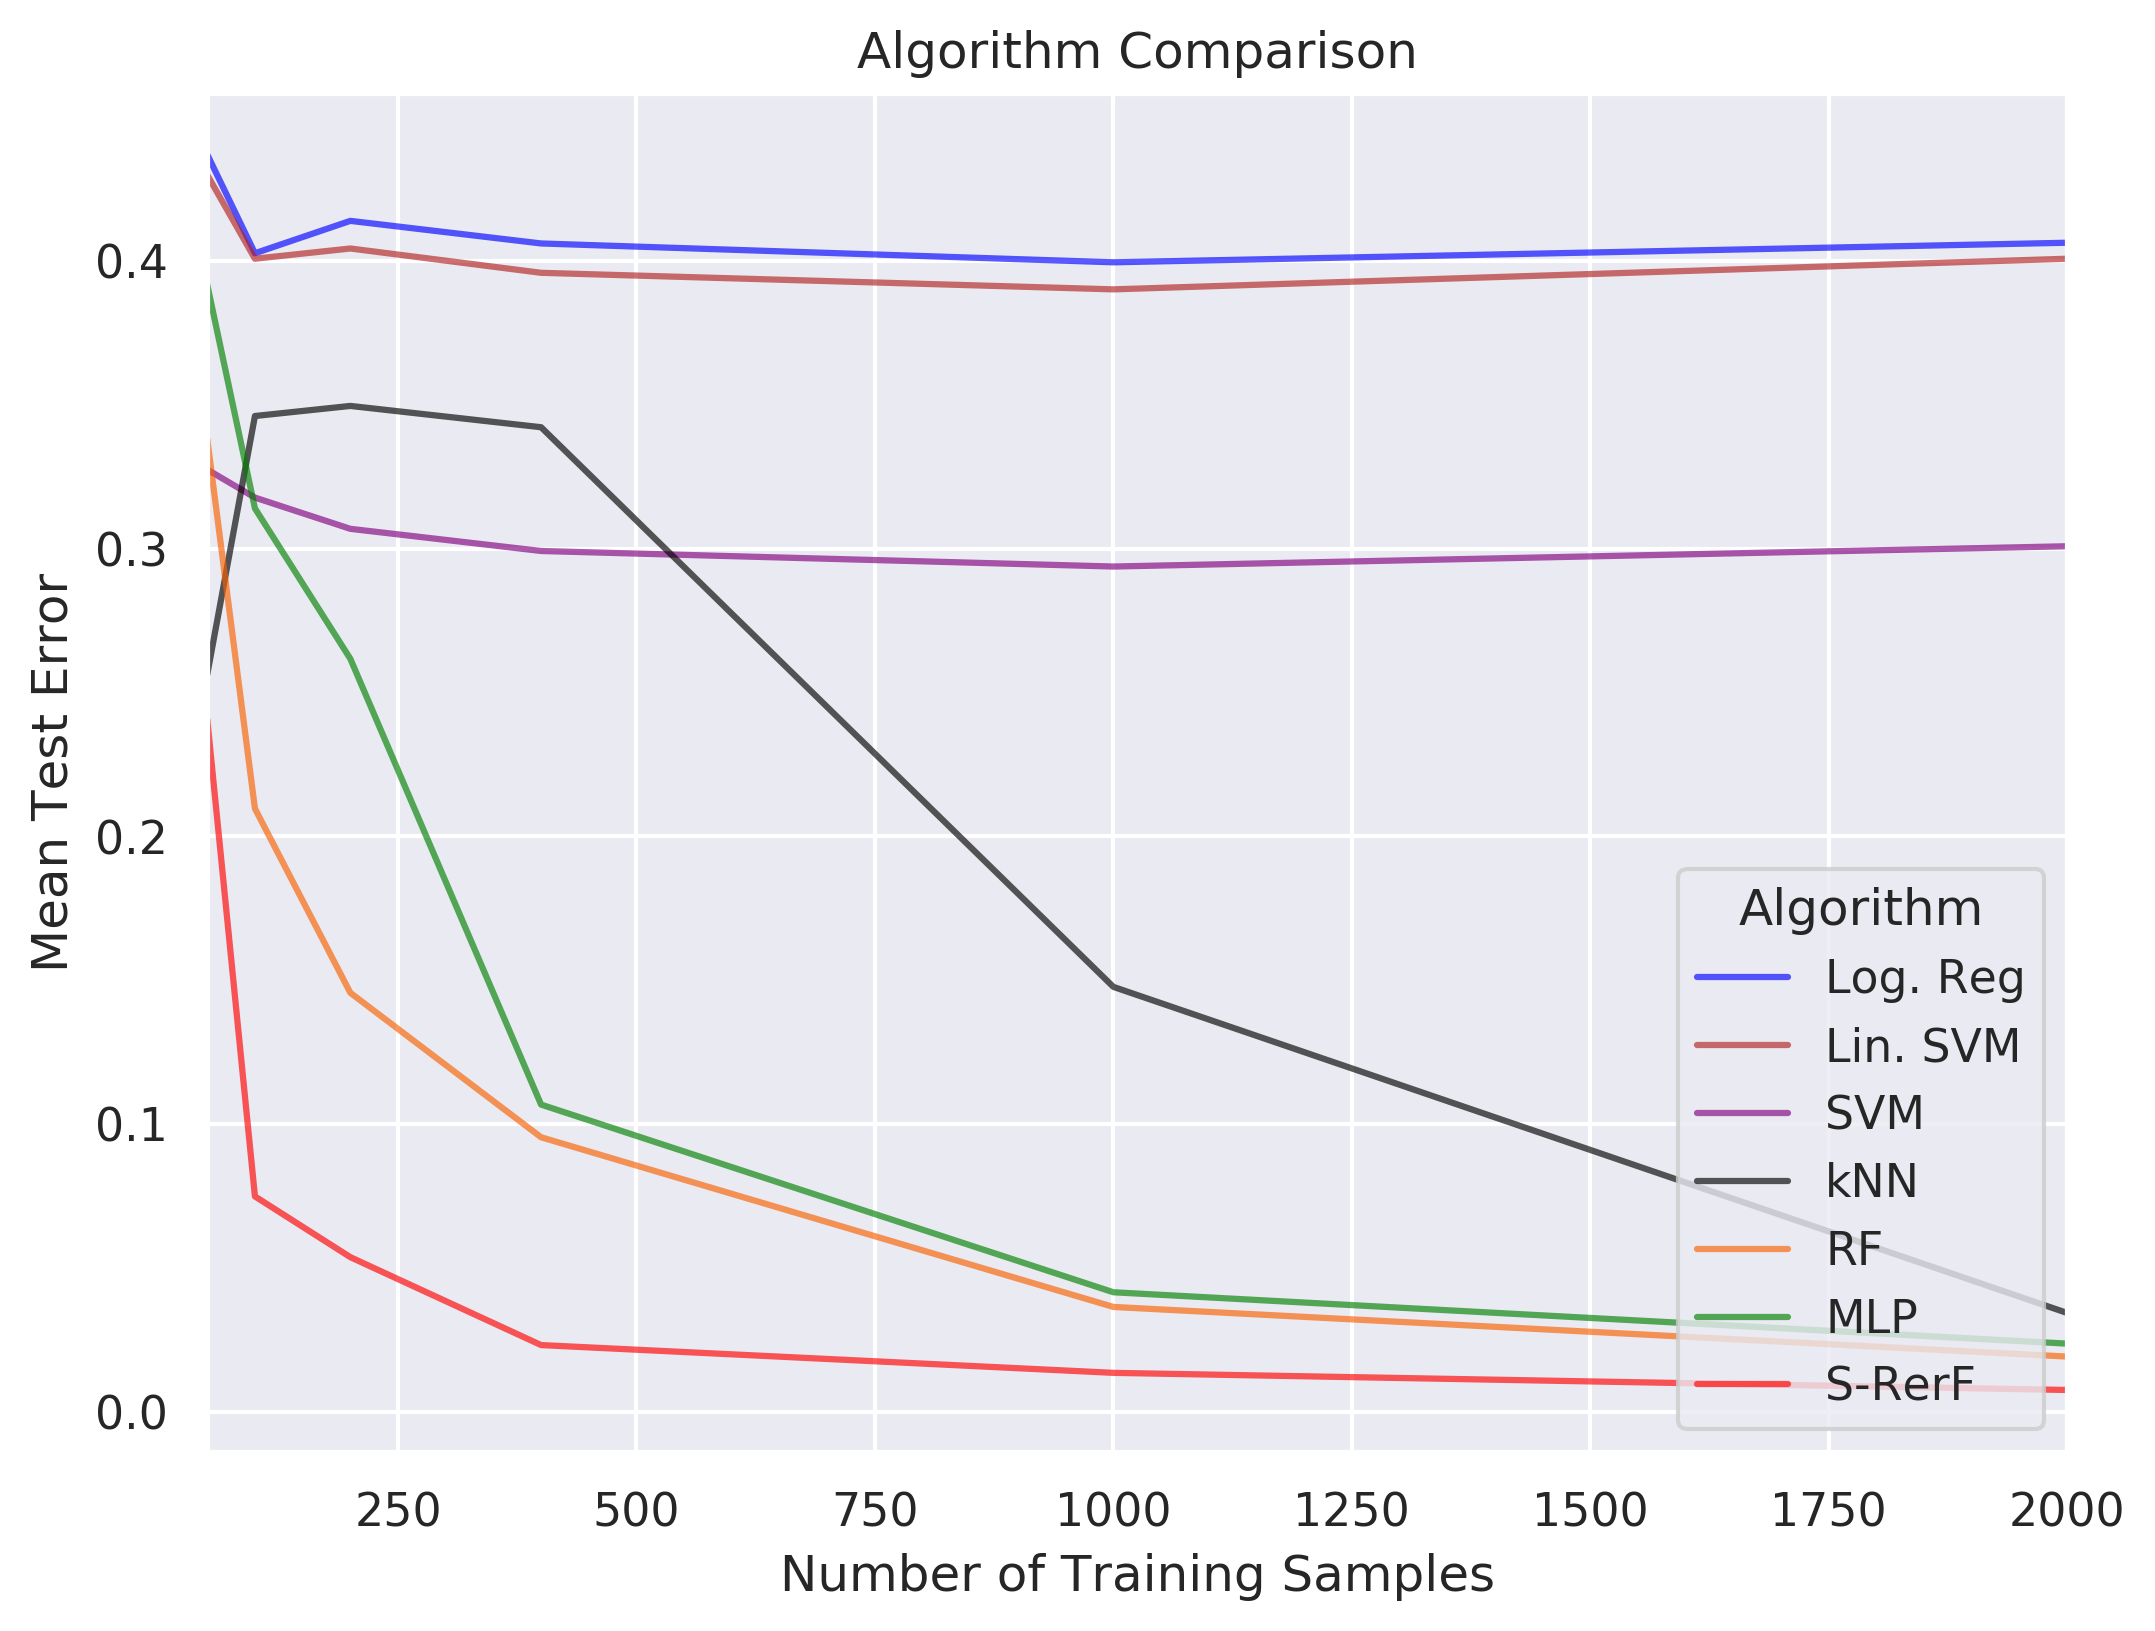

In [35]:

names = {"Log. Reg": "blue", "Lin. SVM":"firebrick", "SVM":"purple",
          "kNN": "black", "RF":"#f86000", "MLP":"green", "S-RerF":"red"}

ncores=1
num_runs=1
n_est=100

classifiers = [
    LogisticRegression(random_state=0, n_jobs=ncores, solver='liblinear'),
    LinearSVC(),
    SVC(C=1.0, kernel='rbf', gamma='auto',random_state=0),
    KNeighborsClassifier(3, n_jobs=ncores),
    RandomForestClassifier(n_estimators=n_est, max_features='auto', n_jobs=ncores),
    MLPClassifier(hidden_layer_sizes=(100, ), random_state=0, max_iter=1000),
    rerfClassifier(projection_matrix="S-RerF",
                   max_features=40,
                   n_jobs=ncores,
                    n_estimators=n_est,
                    oob_score=False,
                    random_state=0,
                    image_height=1,
                    image_width=32,
                    patch_height_max=1,
                    patch_height_min=1,
                    patch_width_max=10,
                    patch_width_min=1
                   )
    ]

# Train each classifier on each data set size, then test
## Prep output file:
f = open('eeg_grasp.csv', 'w+')
f.write("classifier,n,Lhat,trainTime,testTime,iterate\n")
f.flush()

#ns = np.array([50,100,200,400,1000,2000])
ns = np.array([10000,20000])
runList = [(n, clf, run) for n in ns\
           for clf in zip(classifiers, [key for key in names])\
           for run in range(num_runs)]

for n, clf, iteration in tqdm(runList):
        X = X_train[:n]
        y = Y_train[:n]        

        trainStartTime = time.time()
        clf[0].fit(X, y[:,0])
        trainEndTime = time.time()
        trainTime = trainEndTime - trainStartTime

        testStartTime = time.time()
        out = clf[0].predict(X_test)
        testEndTime = time.time()
        testTime = testEndTime - testStartTime

        lhat = np.mean(np.not_equal(out, Y_test[:,0]).astype(int))


        ####("variable,Lhat,trainTime,testTime,iterate")
        f.write(f"{clf[1]}, {n}, {lhat:2.9f}, {trainTime:2.9f}, {testTime:2.9f}, {iteration}\n")
        f.flush()

f.close()


## Read output file log and plot
dat = pd.read_csv("s-rerf_circle_runs.csv")

d1 = pd.DataFrame(columns = ['classifier', 'n', 'Lhat', 'color'])

k = 0
for ni in np.unique(dat['n']):
    for cl in np.unique(dat['classifier']):

        tmp = dat[np.logical_and(dat['classifier'] == cl,dat['n'] == ni)][['n', 'Lhat']]

        se = stats.sem(tmp['Lhat'])

        list(tmp.mean())
        d1.loc[k] = [cl] + list(tmp.mean()) + [names[cl]]
        k += 1


sns.set(style="darkgrid", rc={'figure.figsize':[12,8], 'figure.dpi': 300})
fig, ax = plt.subplots(figsize = (8,6))

for key in names.keys():
    grp = d1[d1['classifier'] == key]
    ax = grp.plot(ax=ax, kind='line', x='n', y='Lhat', label=key, \
            c = names[key], alpha =0.65)
    #ax.set_yscale('log')

plt.legend(loc='lower right',title='Algorithm')
plt.title('Algorithm Comparison')
plt.ylabel('Mean Test Error')
plt.xlabel('Number of Training Samples')
#plt.savefig('./s-rerf_circle_experiment.pdf',dpi=300,format='pdf')
plt.show()

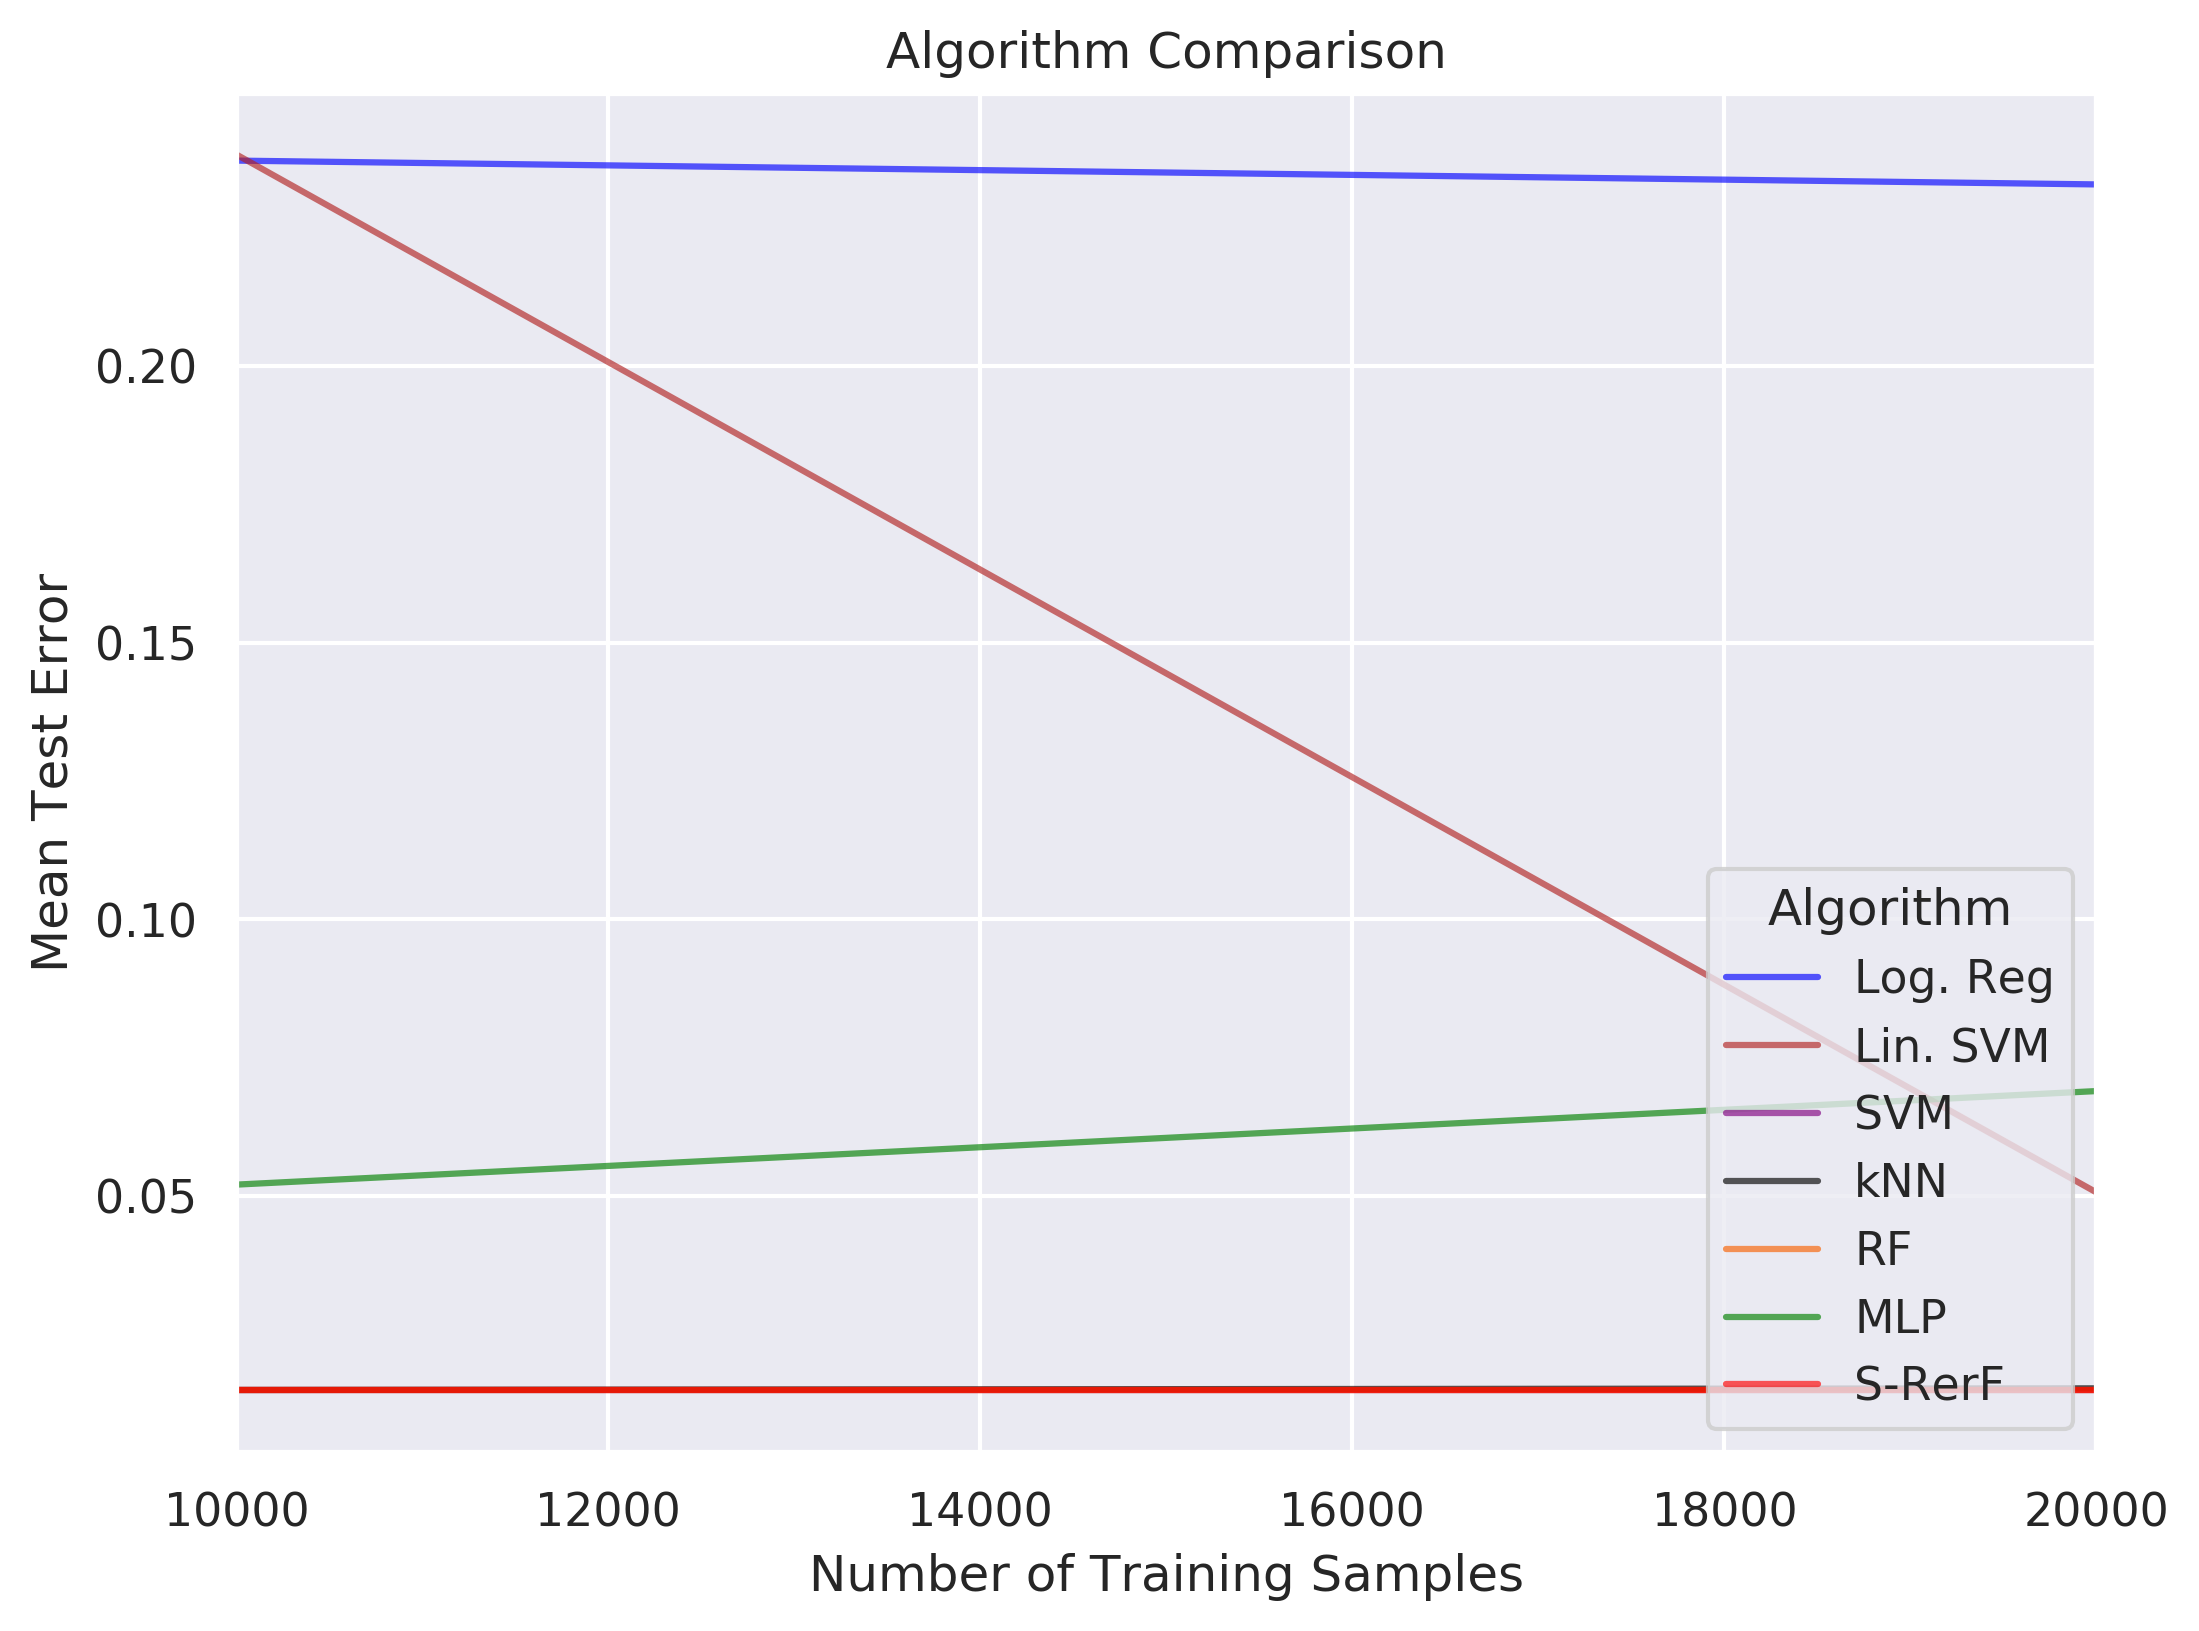

In [36]:
## Read output file log and plot
dat = pd.read_csv("eeg_grasp.csv")

d1 = pd.DataFrame(columns = ['classifier', 'n', 'Lhat', 'color'])

k = 0
for ni in np.unique(dat['n']):
    for cl in np.unique(dat['classifier']):

        tmp = dat[np.logical_and(dat['classifier'] == cl,dat['n'] == ni)][['n', 'Lhat']]

        se = stats.sem(tmp['Lhat'])

        list(tmp.mean())
        d1.loc[k] = [cl] + list(tmp.mean()) + [names[cl]]
        k += 1


sns.set(style="darkgrid", rc={'figure.figsize':[12,8], 'figure.dpi': 300})
fig, ax = plt.subplots(figsize = (8,6))

for key in names.keys():
    grp = d1[d1['classifier'] == key]
    ax = grp.plot(ax=ax, kind='line', x='n', y='Lhat', label=key, \
            c = names[key], alpha =0.65)
    #ax.set_yscale('log')

plt.legend(loc='lower right',title='Algorithm')
plt.title('Algorithm Comparison')
plt.ylabel('Mean Test Error')
plt.xlabel('Number of Training Samples')
#plt.savefig('./s-rerf_circle_experiment.pdf',dpi=300,format='pdf')
plt.show()

In [ ]:
################ Read test data #####################################
    #
    fnames =  glob('../input/test/subj%d_series*_data.csv' % (subject))
    test = []
    idx=[]
    for fname in fnames:
      data=prepare_data_test(fname)
      test.append(data)
      idx.append(np.array(data['id']))
    X_test= pd.concat(test)
    ids=np.concatenate(idx)
    ids_tot.append(ids)
    X_test=X_test.drop(['id' ], axis=1)#remove id
    #transform test data in numpy array
    X_test =np.asarray(X_test.astype(float))

In [ ]:
 ################ Train classifiers ########################################
    lr = LogisticRegression()
    pred = np.empty((X_test.shape[0],6))
    X_train=data_preprocess_train(X_train)
    X_test=data_preprocess_test(X_test)
    for i in range(6):
        y_train= y[:,i]
        print('Train subject %d, class %s' % (subject, cols[i]))
        lr.fit(X_train[::subsample,:],y_train[::subsample])
        pred[:,i] = lr.predict_proba(X_test)[:,1]

    pred_tot.append(pred)

# submission file
submission_file = 'grasp-sub-simple.csv'
# create pandas object for sbmission
submission = pd.DataFrame(index=np.concatenate(ids_tot),
                          columns=cols,
                          data=np.concatenate(pred_tot))

# write file
submission.to_csv(submission_file,index_label='id',float_format='%.3f')